In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pandas as pd
import xarray as xr
import time

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# astropy imports
import astropy.coordinates as coord
from astropy.table import Table, vstack
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, Galactocentric, Galactic

import utils as ut
import plot_utils as pu
import data_retrieve_utils as dru

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
regions = ['bulge', 'disk', 'halo']

data_dic = {}

for region in regions: 
    data_dic[region] = {}
    fold = f'../data/stars_ultra_final/'
    path = f'{fold}{region}_data.fits'

    data = Table.read(path)
    data, galcen = dru.get_galcen_table(data)
    data = dru.preprocess_data(data)

    data_dic[region]['data'] = data
    data_dic[region]['galcen'] = galcen

    data_dic[region]['data'] = dru.bayesian_distance_estimator(data_dic[region]['data'])

    print(region, len(data))

bulge 1660
disk 8327
halo 7734


In [3]:
milky_way = gp.MilkyWayPotential()
H = gp.Hamiltonian(milky_way)

for region in regions: 
    print(region)
    phsp = gd.PhaseSpacePosition(data_dic[region]['galcen'].cartesian)
    data_dic[region]['phsp'] = phsp

    orbits = H.integrate_orbit(phsp, dt=0.5*u.Myr,
                                t1=0*u.Myr, t2=250*u.Myr)
    
    data_dic[region]['orbits'] = orbits

    x_data = orbits.x.value  
    y_data = orbits.y.value
    z_data = orbits.z.value

    data_arr = np.array([x_data, y_data, z_data])

    savefold = '../data/orbits/'
    if not os.path.exists(savefold):
        os.makedirs(savefold)

    np.save(savefold + f'{region}_orbits.npy', data_arr)

bulge
disk
halo


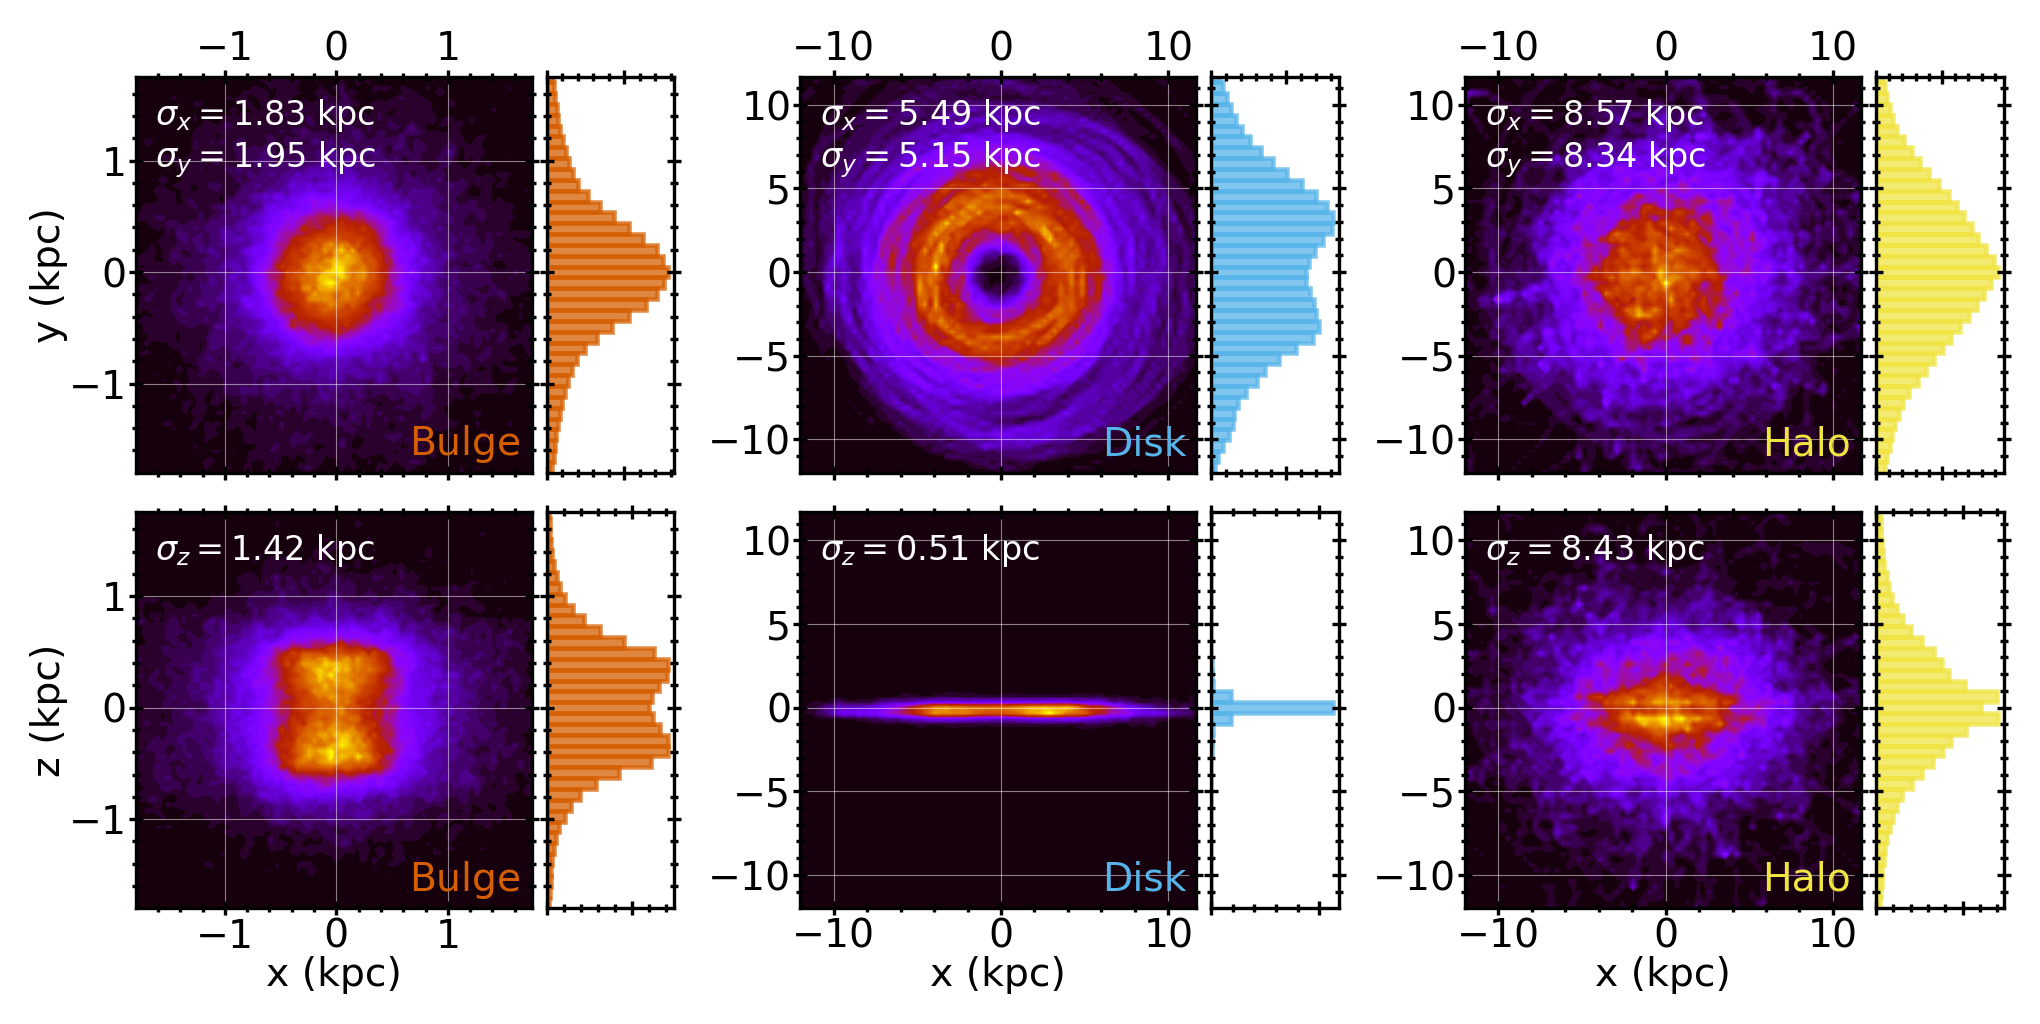

In [4]:
ts = 1.75
cmaps = ['gnuplot', 'gnuplot', 'gnuplot']
colors = [(213/255, 94/255, 0), (0, 158/255, 115/255), (128/255, 128/255, 128/255)]
colors = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]
xy_lim = 12
lims = [xy_lim*0.15, xy_lim, xy_lim]

J = len(regions)

axs, axs_s, fig, fs = pu.plots_and_profiles(ratio=2.25, subplots=(2, J), xlabel='x (kpc)', ylabel=['y (kpc)', 'z (kpc)'],
                                            ts=ts)
rgs = ['Bulge', 'Disk', 'Halo']
for j, region in enumerate(regions):
    orbits = data_dic[region]['orbits']
    x_data, y_data, z_data = orbits.x.value, orbits.y.value, orbits.z.value  

    data_arr = np.array([x_data, y_data, z_data])
    shape = data_arr.shape

    M = 75
    bins = np.linspace(-lims[j], lims[j], M)
    dens, dens_z = np.zeros((M-1, M-1)), np.zeros((M-1, M-1))

    NN = shape[1]
    for k in range(NN):
        H, xedges, yedges = np.histogram2d(data_arr[0,:,k], data_arr[1,:,k], bins=bins)
        H_Z, xedges, yedges = np.histogram2d(data_arr[1,:,k], data_arr[2,:,k], bins=bins)
        dens += H
        dens_z += H_Z

    X, Y = np.meshgrid(xedges, yedges)

    cmap_name = cmaps[j]
    cmap = plt.get_cmap(cmap_name)

    levels = np.linspace(0, dens.max(), 50)
    levels_z = np.linspace(0, dens_z.max(), 50)

    axs[0][j].contourf(X[:-1, :-1], Y[:-1, :-1], dens.T, cmap=cmap, levels=levels)
    axs[1][j].contourf(X[:-1, :-1], Y[:-1, :-1], dens_z.T, cmap=cmap, levels=levels_z)

    # flatten x_data
    



    alph = 0.75
    bins_ = bins[::2]
    axs_s[0][j].hist(y_data.flatten(), bins=bins_, color=colors[j], 
                     alpha=alph, orientation='horizontal', density=True,
                     linewidth=0.2*fs, edgecolor=colors[j])
    axs_s[1][j].hist(z_data.flatten(), bins=bins_, color=colors[j], 
                     alpha=alph, orientation='horizontal', density=True,
                     linewidth=0.2*fs, edgecolor=colors[j])
    # set x_lim
    axs[0][j].set_ylim(-lims[j], bins[-2])
    axs[1][j].set_ylim(-lims[j], bins[-2])
    axs[0][j].set_aspect('equal')
    axs[1][j].set_aspect('equal')

    # remove x_tick_lables of axs_s
    axs_s[0][j].set_xticklabels([])
    axs_s[1][j].set_xticklabels([])

    x_std = np.std(x_data.flatten())
    y_std = np.std(y_data.flatten())
    z_std = np.std(z_data.flatten())

    # add text top right of axs[0][j]
    text = f'$\sigma_x = {x_std:.2f}$ kpc\n$\sigma_y = {y_std:.2f}$ kpc'
    text_2 = f'$\sigma_z = {z_std:.2f}$ kpc'
    x = 0.05
    y = 0.95
    axs[0][j].text(x, y, text, transform=axs[0][j].transAxes, fontsize=fs*ts*0.85, color='white', ha='left', va='top')

    axs[1][j].text(x, y, text_2, transform=axs[1][j].transAxes, fontsize=fs*ts*0.85, color='white', ha='left', va='top')

    for ax in [axs[0][j], axs[1][j]]:

        ax.text(0.975, 0.025, rgs[j],
            transform=ax.transAxes, fontsize=1.75*fs, 
            color=colors[j],
            verticalalignment='bottom', horizontalalignment='right')

savefold = '../figures/orbits/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'heatmap.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')



C:\Users\Pere\AppData\Local\Temp\ipykernel_16148\1637985081.py:29: RuntimeWarning: divide by zero encountered in log10
  colors_corr = np.log10(pu.get_hist_scatter_colors(bp_rp_mag_corr, g_abs_corr,


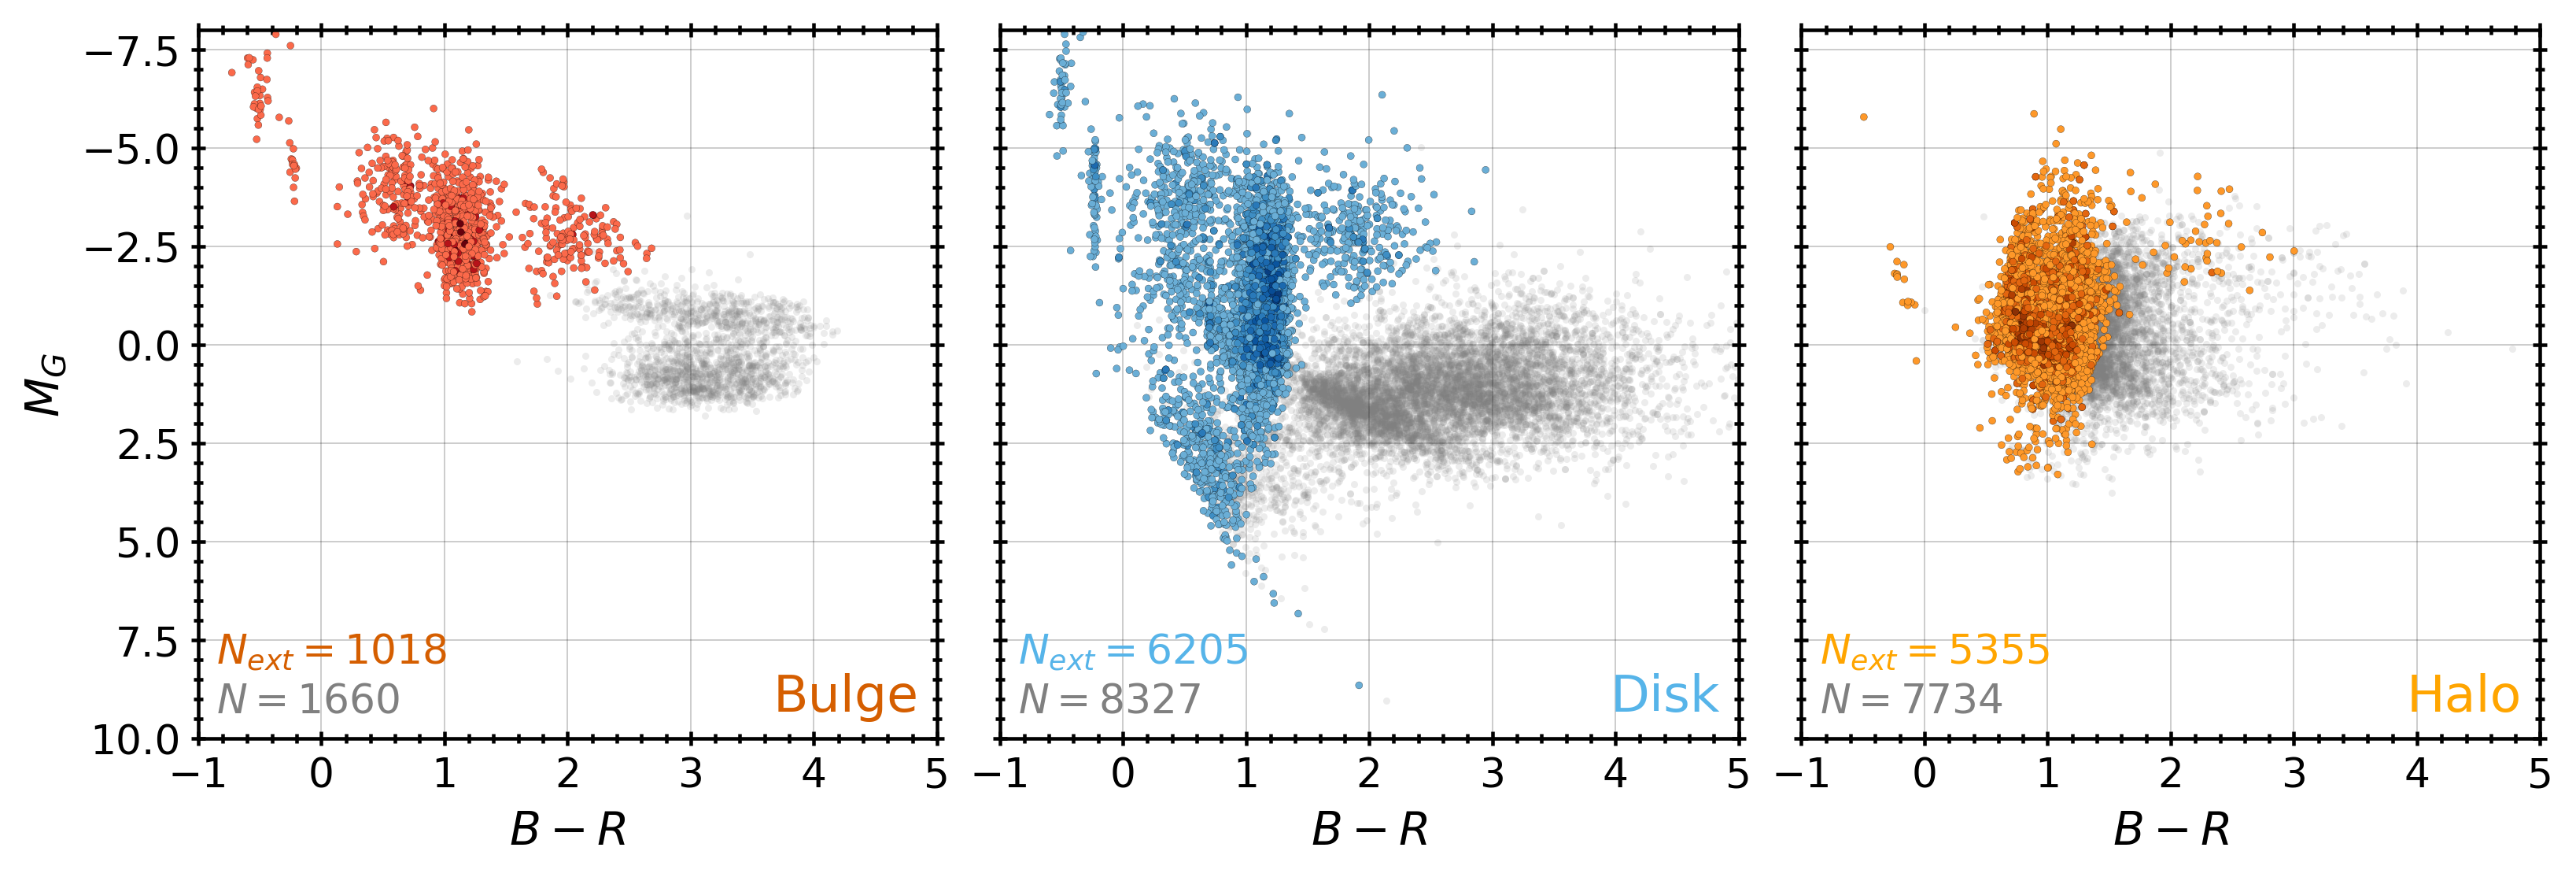

In [400]:
cmaps = ['Reds', 'Blues', 'YlOrBr']
colors_ = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]


ts = 2.25
fig_size, rat = 1080, 3
subplots = (1, 3)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True, sw=0.175)

rgs = ['Bulge', 'Disk', 'Halo']

for j, region in enumerate(regions):




    data = data_dic[region]['data']
    data = dru.preprocess_data(data, distance='distance_median_bayes')

    bp_rp_mag, g_abs = data['bp_rp_mag'], data['g_abs']
    colors = np.log10(pu.get_hist_scatter_colors(bp_rp_mag, g_abs,
                    x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
                    y_lims=[np.min(g_abs), np.max(g_abs)],
                    bins=[200, 200]))
    
    bp_rp_mag_corr = bp_rp_mag  - data['ebpminrp_gspphot'].filled(np.nan)
    g_abs_corr = g_abs - data['ag_gspphot'].filled(np.nan)
    colors_corr = np.log10(pu.get_hist_scatter_colors(bp_rp_mag_corr, g_abs_corr,
                    x_lims=[np.nanmin(bp_rp_mag_corr), np.nanmax(bp_rp_mag_corr)],
                    y_lims=[np.nanmin(g_abs_corr), np.nanmax(g_abs_corr)],
                    bins=[100, 100]))

    if j==2:
        cmap = cmaps[j]
        cmap = plt.get_cmap(cmap)
        # get only first half of colormap
        cmap = cmap_corr(np.linspace(0, 0.5, 256))
        cmap = mpl.colors.ListedColormap(cmap)

    ax = axs[0][j]
    ax.scatter(bp_rp_mag, g_abs, 
                s=0.75*fs, 
                c='grey', 
                #cmap = 'Greys',
                alpha=0.15, zorder=1,
                linewidths=0.0*fs, edgecolor='k')
    

    cmap_corr = cmaps[j]
    cmap_corr = plt.get_cmap(cmap_corr)
    # get only first half of colormap
    cmap_corr = cmap_corr(np.linspace(0.5, 1, 256))
    cmap_corr = mpl.colors.ListedColormap(cmap_corr)

    ax.scatter(bp_rp_mag_corr, g_abs_corr, 
                s=0.75*fs, 
                c=colors_corr, 
                cmap=cmap_corr,
                alpha=1,  zorder=2,
                linewidths=0.01*fs, edgecolor='k')


    # color_max_err = np.percentile(np.array(data['bp_rp_mag_error']),90)
    # lum_max_err = np.percentile(np.array(data['g_abs_error']),90)

    # for xi, yi, x_err_i, y_err_i in zip(bp_rp_mag_corr, g_abs_corr,
    #                                     data['bp_rp_mag_error'], data['g_abs_error']):
        
    #     if (x_err_i > color_max_err) or (y_err_i > lum_max_err):

    #         rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
    #         ax.add_patch(rect)

    if j != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r'$M_G$', fontsize=ts*fs)

    ax.set_xlim(-1,5)
    ax.set_ylim(-8, 10)
    ax.set_xlabel(r'$B-R$', fontsize=ts*fs)
    ax.invert_yaxis()

    ax.text(0.025, 0.025, r'$N = {}$'.format(len(g_abs)), 
            transform=ax.transAxes, fontsize=2*fs, 
            color='grey',
            verticalalignment='bottom', horizontalalignment='left')
    
    c = colors_[j]
    if j==2:
        c = 'orange'

    ax.text(0.975, 0.025, rgs[j],
        transform=ax.transAxes, fontsize=2.5*fs, 
        color=c,
        verticalalignment='bottom', horizontalalignment='right')
    
    # len of g_abs_corr not nan

    len_ = len(g_abs_corr[~np.isnan(g_abs_corr)])
    ax.text(0.025, 0.095, r'$N_{{ext}} = {}$'.format(len_), 
            transform=ax.transAxes, fontsize=2*fs, 
            color=c,
            verticalalignment='bottom', horizontalalignment='left')

savefold = '../figures/orbits/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'HR_diagrams.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')


In [7]:
# compute pericenter, apocenter and eccentricities

for j, region in enumerate(regions):
    print(region)
    orbits = data_dic[region]['orbits']

    peri = orbits.pericenter()
    data_dic[region]['peri'] = peri.value
    print('Pericenter:', np.nanmean(peri.value))
    print('Pericenter std:', np.nanstd(peri.value))
    apo = orbits.apocenter()

    data_dic[region]['apo'] = apo.value
    print('Apocenter:', np.nanmean(apo.value))
    print('Apocenter std:', np.nanstd(apo.value))

    ecc = orbits.eccentricity()
    data_dic[region]['ecc'] = ecc.value
    print('Eccentricity:', np.nanmean(ecc.value))
    print('Eccentricity std:', np.nanstd(ecc.value))
    
    z_max = orbits.zmax()
    data_dic[region]['z_max'] = z_max.value
    print('z_max:', np.nanmean(z_max.value))
    print('z_max std:', np.nanstd(z_max.value))

bulge
Pericenter: 0.3878791180269863
Pericenter std: 0.17420342100117733
Apocenter: 1.4892017123866597
Apocenter std: 1.1674191965107612
Eccentricity: 0.5294143787632986
Eccentricity std: 0.18605697425373333
z_max: 0.6785896748200339
z_max std: 0.4738442805527753
disk


c:\Users\Pere\miniconda3\envs\galenv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pere\miniconda3\envs\galenv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pericenter: 5.035973586912086
Pericenter std: 2.397277864716187
Apocenter: 7.6999591077191605
Apocenter std: 3.749665144037737
Eccentricity: 0.211384728125897
Eccentricity std: 0.13623841296278788
z_max: 0.4167861721681586
z_max std: 0.4298770407000129
halo
Pericenter: 3.5134707013587794
Pericenter std: 2.259328141737497
Apocenter: 10.299402199508448
Apocenter std: 6.258907092328597
Eccentricity: 0.4613382881600211
Eccentricity std: 0.2364562390247251
z_max: 4.890209868877225
z_max std: 4.687770613954752


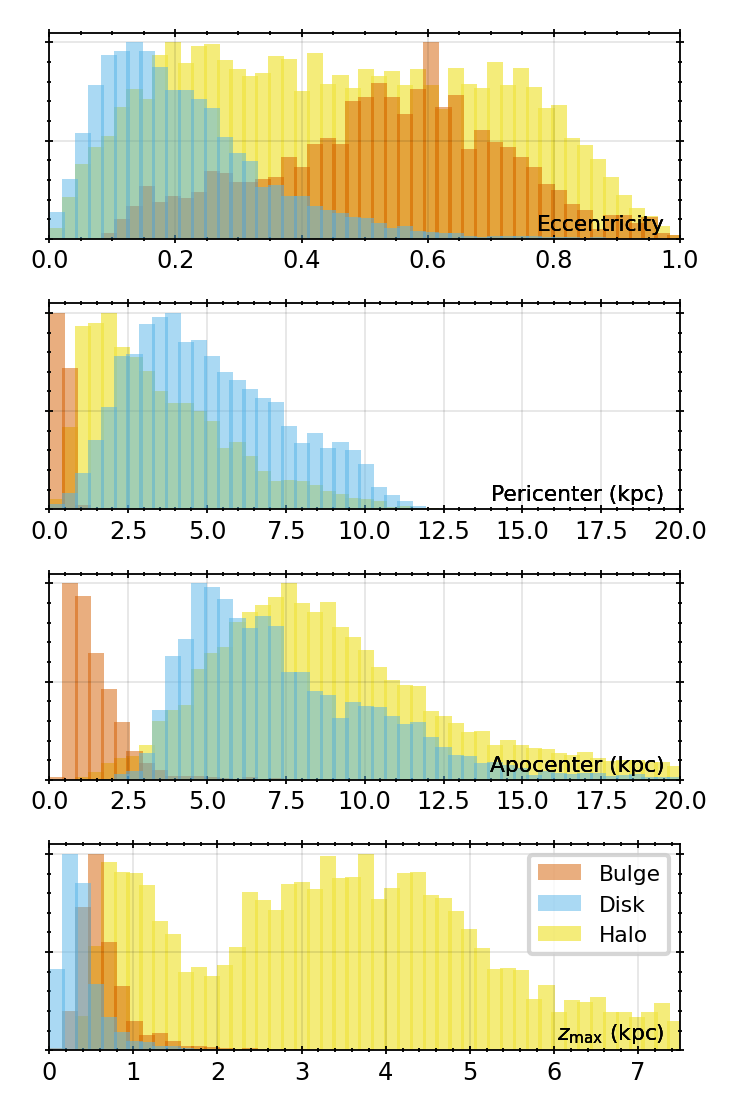

In [276]:
colors_ = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]

ts = 1.8
fig_size, rat = 1080, 0.65
subplots = (4, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True, hspace=0.1)

regs = ['Bulge', 'Disk', 'Halo']
zorders = [1,2,0]
alphas = [0.5, 0.5, 0.7]
for j, region in enumerate(regions):
    peri, apo, ecc = data_dic[region]['peri'], data_dic[region]['apo'], data_dic[region]['ecc']
    z_max = data_dic[region]['z_max']
    values = [ecc, peri, apo, z_max]
    

    def plot_hist(ax, data, lims, label=''):
        bins = np.linspace(lims[0], lims[1], 50)
        hist, x_edges = np.histogram(data, bins=bins, density=True)
        dx = x_edges[1] - x_edges[0]
        hist /= hist.max()
        ax.bar(x_edges[:-1], hist, width=dx+dx/4, color=colors_[j], linewidth=0.5*fs, alpha=alphas[j], zorder=zorders[j], align='edge', label=label)
        ax.set_xlim(lims[0], lims[1])

    axes = [axs[0][0], axs[1][0], axs[2][0], axs[3][0]]
    lims = [[0,1], [0,20], [0,20], [0,7.5]]
    text = ['Eccentricity', 'Pericenter (kpc)', 'Apocenter (kpc)', r'$z_{\mathrm{max}}$ (kpc)']
    x = 0.975
    y = 0.025
    for i, ax in enumerate(axes):
        plot_hist(ax, values[i], lims[i], label=regs[j])
        ax.text(x, y, text[i], transform=axs[i][0].transAxes, fontsize=fs*ts, color='k', ha='right', va='bottom')
        ax.set_yticklabels([])

# plot legend for axs[0][0]
ax = axs[3][0]
ax.legend(loc='upper right', fontsize=fs*ts)

# savefold = '../figures/orbits/'
# if not os.path.exists(savefold):
#     # create the folder if it does not exist
#     os.makedirs(savefold)
# figname = f'orbit_params.png'
# savepath1 = savefold + figname

# fig.savefig(savepath1, dpi=300, bbox_inches='tight')

In [401]:
for j, region in enumerate(regions):
#for j, region in enumerate(['disk']):
    orbits = data_dic[region]['orbits']
    ang = orbits.angular_momentum()
    per = orbits.estimate_period()
    # put it in dic
    data_dic[region]['L'] = ang.value
    data_dic[region]['T'] = per.value

    ang_v = ang.value
    norm_ang_v = np.linalg.norm(ang_v, axis=0)
    mean_ang_v = np.mean(norm_ang_v, axis=0)
    std_ang_v = np.std(norm_ang_v, axis=0)
    DL = std_ang_v/mean_ang_v
    data_dic[region]['DL'] = DL


    # mean_ang_v_ = np.mean(ang_v, axis=1)
    # #mean_ang_v_ /= np.linalg.norm(mean_ang_v, axis=0)
    # dot = np.zeros((ang_v.shape[1], ang_v.shape[2]))
    # for i in range(ang_v.shape[2]):
    #     mang = ang_v[:,:,i] / np.linalg.norm(ang_v[:,:,i], axis=0)
    #     for k in range(ang_v.shape[1]):
    #         ang_v_ = ang_v[:,k,i]
    #         ang_v_ = ang_v_ / np.linalg.norm(ang_v_) 

    #         mean_ang_v_norm = mean_ang_v_[:,i] / np.linalg.norm(mean_ang_v_[:,i])
    #         dot_product = np.dot(mean_ang_v_norm, ang_v_)

    #         dot[k,i] = dot_product

    mean_ang_v_ = np.mean(ang_v, axis=1)

    # Normalize mean_ang_v_ along the first axis
    mean_ang_v_norm = mean_ang_v_ / np.linalg.norm(mean_ang_v_, axis=0, keepdims=True)

    # Normalize ang_v along the first axis
    norm_ang_v_ = ang_v / np.linalg.norm(ang_v, axis=0, keepdims=True)

    # Calculate dot products
    # Reshape mean_ang_v_norm for broadcasting: (3, 1, N)
    mean_ang_v_norm_expanded = mean_ang_v_norm[:, np.newaxis, :]

    # Perform element-wise multiplication and sum over the first axis
    dot = np.sum(mean_ang_v_norm_expanded * norm_ang_v_, axis=0)

    data_dic[region]['dot'] = dot


c:\Users\Pere\miniconda3\envs\galenv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pere\miniconda3\envs\galenv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


bulge
No period computed: 2 (0.12%)
Sign flip: 724 (43.61%)
disk
No period computed: 2551 (30.64%)
Sign flip: 12 (0.14%)
halo
No period computed: 3121 (40.35%)
Sign flip: 448 (5.79%)


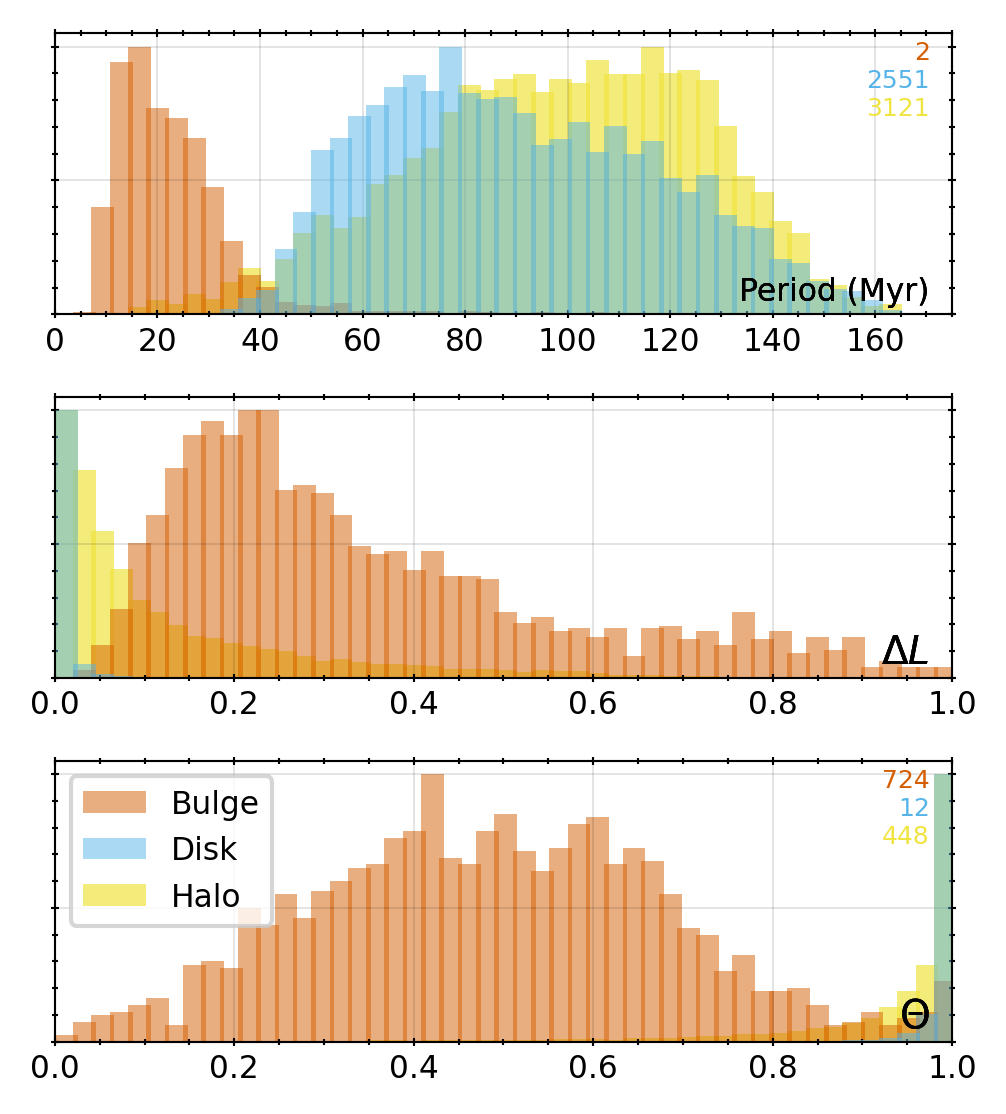

In [410]:
def has_sign_flip(arr):

    non_zero_arr = arr[arr != 0]
    if non_zero_arr.size <= 1:
        return False
    sign_arr = np.sign(non_zero_arr)
    diff = np.diff(sign_arr)
    return np.any(diff != 0)

colors_ = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]

ts = 2.2
fig_size, rat = 1080, 0.9
subplots = (3, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True,
                                         ts=ts, hspace=0.1)

regs = ['Bulge', 'Disk', 'Halo']
zorders = [1,2,0]
alphas = [0.5, 0.5, 0.7]
tsf = [1,1.25,1.25]

for j, region in enumerate(regions):
    period = data_dic[region]['T']
    period_nonan = period[~np.isnan(period)]
    n_nans = np.count_nonzero(np.isnan(period))
    DL = data_dic[region]['DL']
    dot = data_dic[region]['dot']
    dot_std = np.std(dot, axis=0)
    dot_mean = np.mean(dot, axis=0)
    sgn_ = 0
    for l in range(dot_mean.shape[0]):
        if has_sign_flip(dot[:,l]):
            sgn_ += 1
        

    values = [period_nonan, DL, dot_mean]
    #count number of nans
    
    print(f'{region}')
    print(f'No period computed: {n_nans} ({100*n_nans/dot_mean.shape[0]:0.2f}%)')
    print(f'Sign flip: {sgn_} ({100*sgn_/dot_mean.shape[0]:0.2f}%)')
    
    def plot_hist(ax, data, lims, label=''):
        bins = np.linspace(lims[0], lims[1], 50)
        hist, x_edges = np.histogram(data, bins=bins, density=True)
        dx = x_edges[1] - x_edges[0]
        hist /= hist.max()
        ax.bar(x_edges[:-1], hist, width=dx+dx/4, color=colors_[j], linewidth=0.5*fs, alpha=alphas[j], zorder=zorders[j], align='edge', label=label)
        ax.set_xlim(lims[0], lims[1])

    axes = [axs[0][0], axs[1][0], axs[2][0]]
    lims = [[0,175], [0,1], [0,1]]
    text = ['Period (Myr)', '$\Delta L$', '$\Theta$']
    x = 0.975
    y = 0.025
    for i, ax in enumerate(axes):
        plot_hist(ax, values[i], lims[i], label=regs[j])
        ax.text(x, y, text[i], transform=axs[i][0].transAxes, fontsize=fs*ts*tsf[i], color='k', ha='right', va='bottom')
        ax.set_yticklabels([])

    # text upper right in axs[0][0] 
    # ax = axs[0][0]
    # x = 0.975
    # y = 0.975 - 0.1*j
    # text = f'{n_nans:0.0f}'
    # ax.text(x, y, text, transform=ax.transAxes, fontsize=fs*ts*0.8, color=colors_[j], ha='right', va='top')

    # axs[2][0].text(x, y, f'{sgn_:0.0f}', transform=axs[2][0].transAxes, fontsize=fs*ts*0.8, color=colors_[j], ha='right', va='top')

# plot legend for axs[0][0]
ax = axs[2][0]
ax.legend(loc='upper left', fontsize=fs*ts)

savefold = '../figures/orbits/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'angular_momentum.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')

In [411]:
774/1660

0.46626506024096387

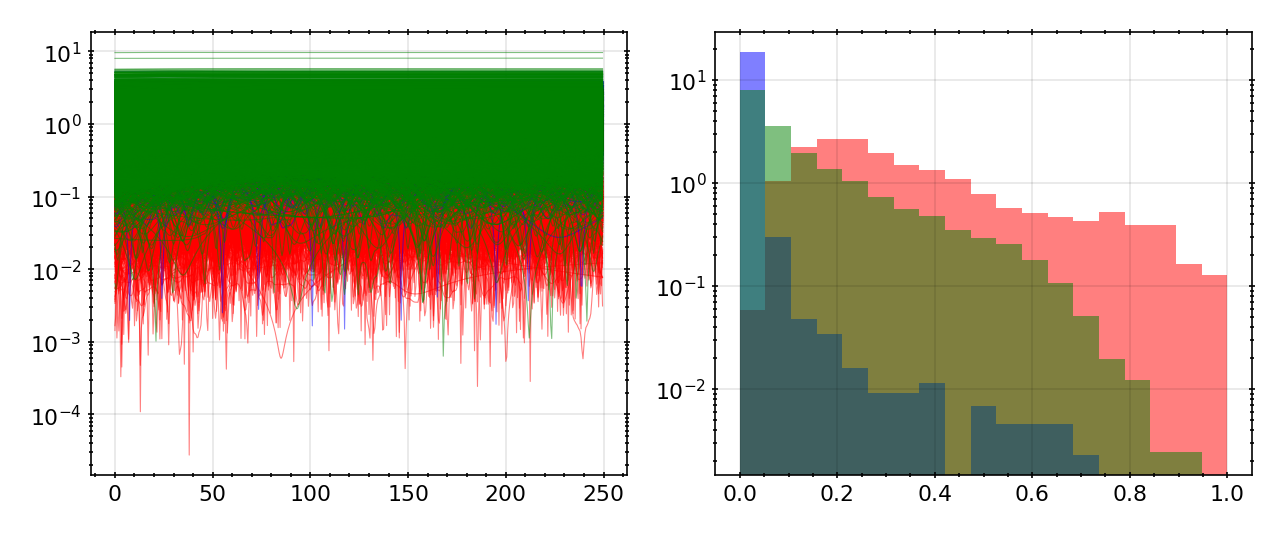

In [283]:

colors_ = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]

ts = 1.8
fig_size, rat = 1080, 0.65
subplots = (4, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True, hspace=0.1)

tsf = [1,1.5,1.5]
regs = ['Bulge', 'Disk', 'Halo']
zorders = [1,2,0]
alphas = [0.5, 0.5, 0.7]
for i, region in enumerate(regions):




    dif_angs = []
    orbits = data_dic[region]['orbits']
    M = orbits.shape[1]
    for j in range(M):
        orbit = orbits[:, j]
        x, y, z = orbit.x.value, orbit.y.value, orbit.z.value
        v_x, v_y, v_z = orbit.v_x.value, orbit.v_y.value, orbit.v_z.value

        ang_mom = np.cross(np.array([x,y,z]).T, np.array([v_x, v_y, v_z]).T)
        ang_mom = np.linalg.norm(ang_mom, axis=1)
        ang_mom_mean = np.mean(ang_mom)
        ang_mom_std = np.std(ang_mom)
        dif_ang = np.max(ang_mom) - np.min(ang_mom)
        dif_angs.append(ang_mom_std/ang_mom_mean)

        axs[0][0].plot(t, ang_mom, color=colors[i], alpha=0.5, lw=0.1*fs)

    axs[0][1].hist(dif_angs, bins=bins, color=colors[i], density=True, alpha=0.5)





for j, region in enumerate(regions):
    peri, apo, ecc = data_dic[region]['peri'], data_dic[region]['apo'], data_dic[region]['ecc']
    z_max = data_dic[region]['z_max']
    values = [ecc, peri, apo, z_max]
    

    def plot_hist(ax, data, lims, label=''):
        bins = np.linspace(lims[0], lims[1], 50)
        hist, x_edges = np.histogram(data, bins=bins, density=True)
        dx = x_edges[1] - x_edges[0]
        hist /= hist.max()
        ax.bar(x_edges[:-1], hist, width=dx+dx/4, color=colors_[j], linewidth=0.5*fs, alpha=alphas[j], zorder=zorders[j], align='edge', label=label)
        ax.set_xlim(lims[0], lims[1])

    axes = [axs[0][0], axs[1][0], axs[2][0], axs[3][0]]
    lims = [[0,1], [0,20], [0,20], [0,7.5]]
    text = ['Eccentricity', 'Pericenter (kpc)', 'Apocenter (kpc)', r'$z_{\mathrm{max}}$ (kpc)']
    x = 0.975
    y = 0.025
    for i, ax in enumerate(axes):
        plot_hist(ax, values[i], lims[i], label=regs[j])
        ax.text(x, y, text[i], transform=axs[i][0].transAxes, fontsize=fs*ts*tsf[j], color='k', ha='right', va='bottom')
        ax.set_yticklabels([])

# plot legend for axs[0][0]
ax = axs[3][0]
ax.legend(loc='upper right', fontsize=fs*ts)

savefold = '../figures/orbits/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'orbit_params.png'
savepath1 = savefold + figname

fig.savefig(savepath1, dpi=300, bbox_inches='tight')



In [ ]:
fig_size, rat = 500, 2.5
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True)

colors = ['red', 'blue', 'green']
z_lim = 4
xy_lim = 10
xy_lim2 = 7.5

M = 50
zorders = [2,3,1]


bins = np.linspace(0, 300, 20)
for i, region in enumerate(regions):
    maxs = []
    orbits = data_dic[region]['orbits']
    for j in range(M):
        orbit = orbits[:, j]
        x, y, z = orbit.x.value, orbit.y.value, orbit.z.value
        theta = np.arctan2(y, x)
        x_fft = np.fft.fft(theta)
        frequencies = np.fft.fftfreq(len(x))
        pos_freq = frequencies > 0
        x_fft_pos = x_fft[pos_freq]
        frequencies_pos = frequencies[pos_freq] 
        x_max_arg = np.argmax(np.abs(x_fft_pos))
        freq_idxmax = frequencies_pos[x_max_arg]
        #x_magnitude_pos = np.abs(x_fft_pos) 
        maxs.append(1/freq_idxmax)

    axs[0][0].hist(maxs, bins=bins, color=colors[i], density=True, alpha=0.5)

# x scale log
#axs[0][0].set_xscale('log')

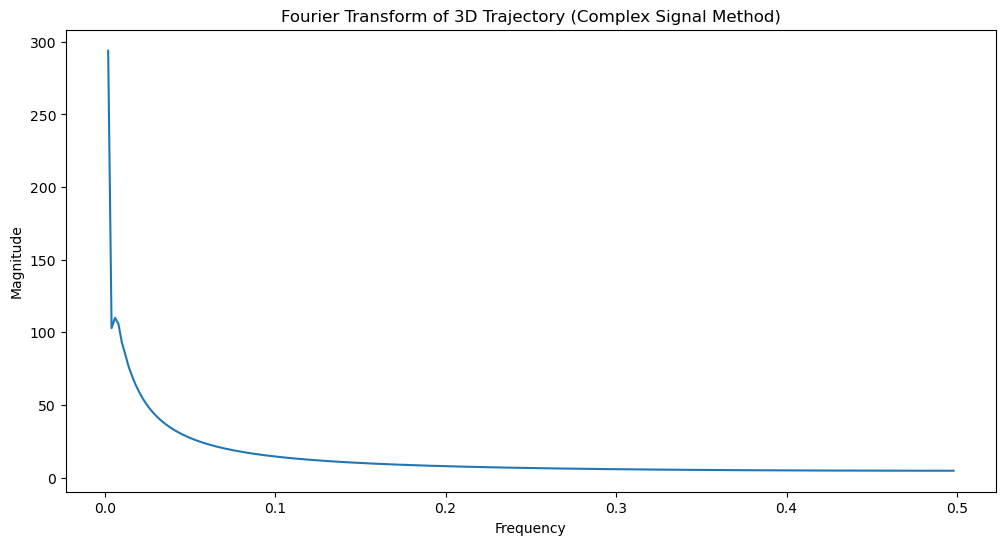

In [144]:
# Combine into a single complex signal
complex_signal = x + 1j * (y)

# Fourier Transform
complex_fft = np.fft.fft(complex_signal)

# Frequencies
frequencies = np.fft.fftfreq(len(complex_signal))

# Consider only positive frequencies
pos_freq = frequencies > 0
complex_fft_pos = complex_fft[pos_freq]
frequencies_pos = frequencies[pos_freq]

# Magnitude
magnitude = np.abs(complex_fft_pos)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(frequencies_pos, magnitude)
plt.title('Fourier Transform of 3D Trajectory (Complex Signal Method)')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In [205]:
indices = []
z_max = 1.5
for i in range(orbits.shape[1]):
    zs = orbits.z.value[:, i]
    if np.any(np.abs(zs) > z_max):
        indices.append(i)

orbits_filtered = orbits[:, indices]

In [ ]:
fig_size, rat = 500, 2.25
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_size=fig_size, ratio=rat, subplots=subplots,
                                        minor=True)

colors = [(213/255, 94/255, 0), (0, 158/255, 115/255), (128/255, 128/255, 128/255)]
colors = [(213/255, 94/255, 0), (86/255, 180/255, 233/255), (240/255, 228/255, 66/255)]
#colors = ['r', 'b', 'g']
z_lim = 11.4
xy_lim = 11.4
xy_lim2 = 11.4


zorders = [2,3,1]

lw = 0.4
alpha = 0.3
for i, region in enumerate(regions):
    orbits = data_dic[region]['orbits']
    M = orbits.shape[1]
    M = 20
    for j in range(M):
        orbit = orbits[:, j]
        x, y, z = orbit.x.value, orbit.y.value, orbit.z.value
        axs[0][0].plot(x, y, c=colors[i], alpha=alpha, lw=lw*fs, zorder=zorders[i])
        axs[0][1].plot(x, z, c=colors[i], alpha=alpha, lw=lw*fs, zorder=zorders[i])

        # axes facecolor to grey
        cs = 0.25
        facecolor = (cs,cs,cs) 
        axs[0][0].set_facecolor(facecolor)
        axs[0][1].set_facecolor(facecolor)

    
        
axs[0][0].set_xlim(-xy_lim, xy_lim)
axs[0][0].set_ylim(-xy_lim, xy_lim)
# set equal axes
axs[0][0].set_aspect('equal')


axs[0][1].set_xlim(-xy_lim2, xy_lim2)
axs[0][1].set_ylim(-z_lim, z_lim)
# ste aspect equal
axs[0][1].set_aspect('equal')



#flatten axs
axx = [ax for ax_row in axs for ax in ax_row]
